Dataset and DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
# TODO: implement here your custom dataset class for Cityscapes


class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(self.root_dir, 'images', self.split)
        self.label_dir = os.path.join(self.root_dir, 'gtFine', self.split)
        self.image_folders = os.listdir(self.image_dir)
        self.images = []

        for folder in self.image_folders:
            images_in_folder = os.listdir(os.path.join(self.image_dir, folder))
            self.images.extend(images_in_folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        folder_name = self.images[idx].split('_')[0]
        img_name = os.path.join(self.image_dir, folder_name, self.images[idx])
        label_name = os.path.join(self.label_dir, folder_name, self.images[idx].replace('leftImg8bit', 'gtFine_labelTrainIds'))

        image = np.array(Image.open(img_name).convert('RGB'))[::2,::2]
        # image = torch.tensor(image)
        label = np.array(Image.open(label_name))[::2,::2]
        label = torch.tensor(label).long()
        # This code need to updated.
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/MLDL2024_project1/datasets/Cityspaces', transform=transform, split='train')
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/MLDL2024_project1/datasets/Cityspaces', transform=transform, split='val')

In [5]:
# Create a DataLoader
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_dataset, batch_size=2, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [6]:
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of validation samples: {num_val_samples}')

Number of training samples: 1572
Number of validation samples: 500


Build model

In [7]:
import torch
import torch.nn as nn

affine_par = True


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        # change
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = dilation
        # change
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class ClassifierModule(nn.Module):
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(inplanes, num_classes, kernel_size=3, stride=1, padding=padding,
                          dilation=dilation, bias=True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list) - 1):
            out += self.conv2d_list[i + 1](x)
        return out


class ResNetMulti(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNetMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)  # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if (stride != 1
                or self.inplanes != planes * block.expansion
                or dilation == 2
                or dilation == 4):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer6(x)

        x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')

        # used for auxiliary loss function
        # if self.training == True:
        #     return x, None, None

        return x

    def get_1x_lr_params_no_scale(self):
        """
        This generator returns all the parameters of the net except for
        the last classification layer. Note that for each batchnorm layer,
        requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
        any batchnorm parameter
        """
        b = []

        b.append(self.conv1)
        b.append(self.bn1)
        b.append(self.layer1)
        b.append(self.layer2)
        b.append(self.layer3)
        b.append(self.layer4)

        for i in range(len(b)):
            for j in b[i].modules():
                jj = 0
                for k in j.parameters():
                    jj += 1
                    if k.requires_grad:
                        yield k

    def get_10x_lr_params(self):
        """
        This generator returns all the parameters for the last layer of the net,
        which does the classification of pixel into classes
        """
        b = []
        if self.multi_level:
            b.append(self.layer5.parameters())
        b.append(self.layer6.parameters())

        for j in range(len(b)):
            for i in b[j]:
                yield i

    def optim_parameters(self, lr):
        return [{'params': self.get_1x_lr_params_no_scale(), 'lr': lr},
                {'params': self.get_10x_lr_params(), 'lr': 10 * lr}]


def get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='/content/drive/MyDrive/MLDL_project/MLDL2024_project1/DeepLab_resnet_pretrained_imagenet.pth'):
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes)

    # Pretraining loading
    if pretrain:
        print('Deeplab pretraining loading...')
        saved_state_dict = torch.load(pretrain_model_path)

        new_params = model.state_dict().copy()
        for i in saved_state_dict:
            i_parts = i.split('.')
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
        model.load_state_dict(new_params, strict=False)

    return model

Trainning and validation process

In [8]:
def fast_hist(a, b, n):
    '''
    a and b are ground truth and predict respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [9]:
def total_hist(outputs, labels, num_classes):
    hist = 0
    for i in range(len(outputs)):
        output, label = outputs[i].cpu().detach().numpy().reshape(-1,), labels[i].cpu().detach().numpy().reshape(-1,)
        hist += fast_hist(label, output, num_classes)
    return hist

In [10]:
def train(epoch, model, dataloader_train, criterion, optimizer):
  model.train()
  running_loss = 0.0
  hist = 0
  for i, (inputs, labels) in enumerate(dataloader_train, 0):
      inputs, labels = inputs.cuda(), labels.cuda()
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      outputs = torch.argmax(outputs, dim=1)
      hist += total_hist(outputs, labels, 19)
  avg_loss = running_loss / len(dataloader_train)
  miou = np.mean(per_class_iou(hist))
  print(f"Epoch{epoch+1} Avg. Training Loss: {avg_loss}, mIoU: {miou}")
  return avg_loss, miou

In [13]:
def validation(model, dataloader_val, criterion):
  model.eval()
  val_loss = 0.0
  hist = 0

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(dataloader_val, 0):
          inputs, labels = inputs.cuda(), labels.cuda()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          outputs = torch.argmax(outputs, dim=1)
          hist += total_hist(outputs, labels, 19)

  avg_val_loss = val_loss / len(dataloader_val)
  miou = np.mean(per_class_iou(hist))
  print(f"Avg. Validation Loss: {avg_val_loss}, mIoU: {miou}")
  return avg_val_loss, miou

In [14]:
import torch.optim as optim

model = get_deeplab_v2().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  #Since our batch size is only 2, so we need to choose a small learning rate

# training model
epochs = 5

miou_train_list = []
miou_val_list = []
models = []
for epoch in range(epochs):
    _, miou_train = train(epoch, model, dataloader_train, criterion, optimizer)
    _, miou_val = validation(model, dataloader_val, criterion)
    miou_train_list.append(miou_train)
    miou_val_list.append(miou_val)
    models.append(model.state_dict())


print('Finished Training')

Deeplab pretraining loading...
Epoch1 Avg. Training Loss: 0.41441423835531443, mIoU: 0.41958550891551444
Avg. Validation Loss: 0.29614314791560176, mIoU: 0.5018329252466791
Epoch2 Avg. Training Loss: 0.21189815613604684, mIoU: 0.5994390411592453
Avg. Validation Loss: 0.2516351816058159, mIoU: 0.5478789980411563
Epoch3 Avg. Training Loss: 0.16791735632634194, mIoU: 0.6741038473386528
Avg. Validation Loss: 0.2813507997691631, mIoU: 0.536058801732937
Epoch4 Avg. Training Loss: 0.15135646700081784, mIoU: 0.7211135555220421
Avg. Validation Loss: 0.2502238897383213, mIoU: 0.5489393351599943
Epoch5 Avg. Training Loss: 0.12860143770470875, mIoU: 0.7538145034051492
Avg. Validation Loss: 0.2335504952967167, mIoU: 0.5847067989526772
Finished Training


In [15]:
# save best model
import os
DIR = '/content/drive/MyDrive/MLDL_project/MLDL2024_project1/models/deeplabv2/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'deepLabV2_epoch{epochs}.pth'

# delete old model files
if os.path.exists(PATH):
    os.remove(PATH)

model = get_deeplab_v2().cuda()
model.load_state_dict(models[np.argmax(np.array(miou_val_list))])
torch.save(model.state_dict(), PATH)

Deeplab pretraining loading...


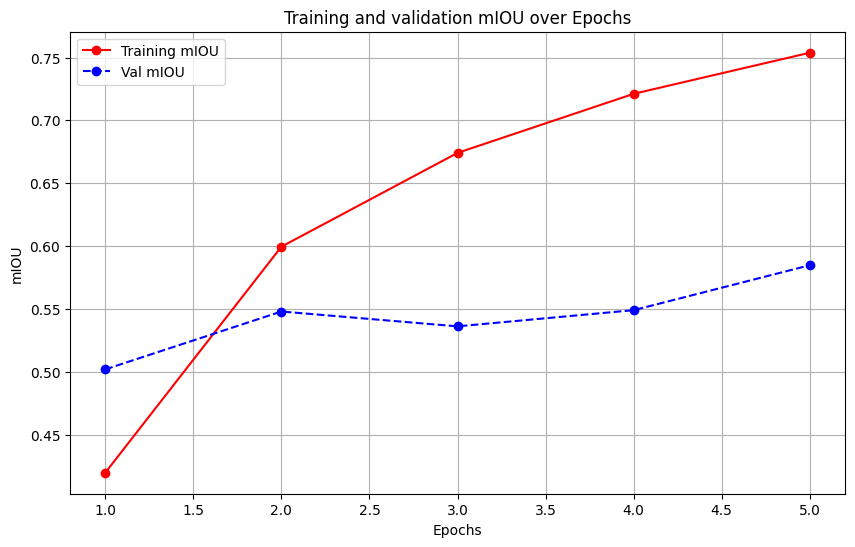

In [16]:
# visualization and find best model
import matplotlib.pyplot as plt

epochs_list = np.arange(1, epochs+1)
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list, marker='o', linestyle='-', color='r', label='Training mIOU')
plt.plot(epochs_list, miou_val_list, marker='o', linestyle='--', color='b', label='Val mIOU')

plt.title('Training and validation mIOU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIOU')

plt.legend()
plt.grid(True)
plt.show()

Flops

In [17]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=1c63eb996eb555b1dd7394638d0525bbebfbf412e804981ae2369c56de2341f9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=69a04a78b5917d833aec5e1f5a68e642f980d2531ffdffba695535acc51f1785
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [18]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# -----------------------------
# Initizialize your model here
# -----------------------------

height = train_dataset[0][0].shape[0]
width = train_dataset[0][0].shape[1]
image = torch.zeros((1, 3, height, width)).cuda()

flops = FlopCountAnalysis(model, image)
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 2.911G     |
|  conv1                         |  9.408K                |  4.817M    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  0.164M    |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  56.768M   |
|   layer1.0                     |   75.008K              |   19.847M  |
|    layer1.0.conv1              |    4.096K              |    1.057M  |
|    layer1.0.bn1                |    0.128K              |    82.56K  |
|    layer1.0.conv2              |    36.864K             |    9.511M  |
|    layer1.0.bn2                |    0.128K       

Latency and FPS

In [21]:
# latency and FPS
import time

height = train_dataset[0][0].shape[0]
width = train_dataset[0][0].shape[1]
image = np.random.randint(0,256,(height, width, 3)) / 255.
image = transform(image)
image = torch.unsqueeze(image, dim=0).float().cuda()

iterations = 1000
latency = np.zeros(iterations)
fps = np.zeros(iterations)
for i in range(iterations):
  start = time.time()
  output = model(image)
  end = time.time()
  time_diff_seconds = end - start
  latency[i] = time_diff_seconds
  fps[i] = 1/time_diff_seconds

meanLatency = np.mean(latency)*1000
stdLatency = np.std(latency)*1000
meanFPS = np.mean(fps)
stdFPS = np.std(fps)

print(f"Mean Latency: {meanLatency} ms")
print(f"Std Latency: {stdLatency} ms")
print(f"Mean FPS: {meanFPS}")
print(f"Std FPS: {stdFPS}")

Mean Latency: 21.275926113128662 ms
Std Latency: 4.535507116131966 ms
Mean FPS: 48.69826474419814
Std FPS: 8.13876782093308


Number of parameters

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 43901068
